*Compiled on Feb 13, 2019 with scanpy v.1.4   

# Clustering 3k PBMCs following a Seurat Tutorial

Scanpy allows to reproduce most of Seurat's ([Satija *et al.*, 2015](https://doi.org/10.1038/nbt.3192)) standard clustering tutorial as described on http://satijalab.org/seurat/pbmc3k_tutorial.html (July 26, 2017). We gratefully acknowledge  the Seurat authors for publishing the tutorial!

The data consists in *3k PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)).

In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata
import bbknn

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()
results_file = 'lung5.h5ad'

scanpy==1.4 anndata==0.6.18 numpy==1.16.1 scipy==1.2.1 pandas==0.24.1 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
metadata = pd.read_csv('/home/jovyan/tisstab/analysis/allsamples.csv', sep = ',', index_col = 0)

metadata_oes = metadata.loc[metadata['organ'] == 'Lung']
metadata_oes.head()

,organ,patient,timepoint
sample,,,
HCATisStab7509734,Lung,343B,0h
HCATisStab7509735,Lung,343B,24h
HCATisStab7509736,Lung,343B,72h
HCATisStab7587202,Lung,356C,0h
HCATisStab7587205,Lung,356C,12h


In [3]:
path = '/home/jovyan/tisstab/data/'
filenames = metadata_oes.index
adatas = [sc.read_10x_mtx(path + filename + '/filtered_gene_bc_matrices/GRCh38/') for filename in filenames]
for i in range(len(adatas)):
    adatas[i].obs['sample'] = metadata_oes.index[i]
    for col in metadata_oes.columns:
        adatas[i].obs[col] = metadata_oes[col][i]
adata = adatas[0].concatenate(adatas[1:], batch_categories = metadata_oes.index)
adata

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading fr

AnnData object with n_obs × n_vars = 79111 × 33694 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200'

In [4]:
adata.write('/home/jovyan/tisstab/data/lung.h5ad')


... storing 'organ' as categorical
... storing 'patient' as categorical
... storing 'sample' as categorical
... storing 'timepoint' as categorical


In [24]:
adata = sc.read('/home/jovyan/tisstab/data/lung.h5ad')

In [26]:
import bbknn

## Preprocessing

Basic filtering.

In [27]:
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13552 cells that have less than 300 genes expressed
filtered out 8490 genes that are detected in less than 3 cells


Plot some information about mitochondrial genes, important for quality control. Note that you can also retrieve mitochondrial genes using `sc.queries.mitochondrial_genes_biomart('www.ensembl.org', 'mmusculus')`.

In [28]:
mito_genes = [name for name in adata.var_names if name.startswith('MT-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

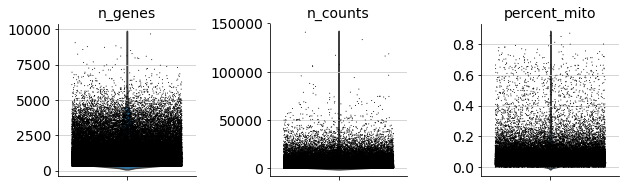

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

Populating the interactive namespace from numpy and matplotlib


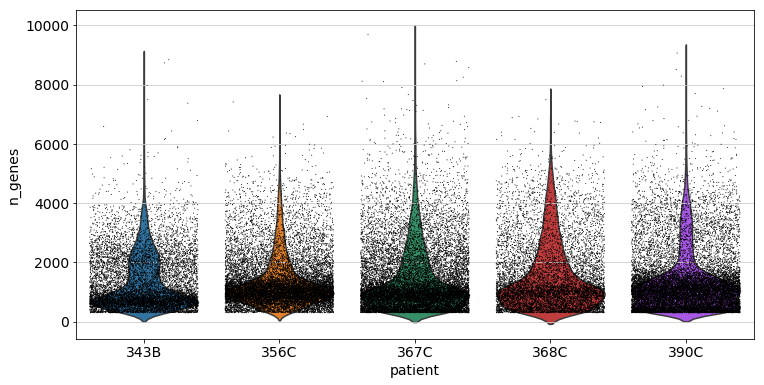

In [30]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
sc.pl.violin(adata, ['n_genes'],
             jitter=0.4, groupby='patient')


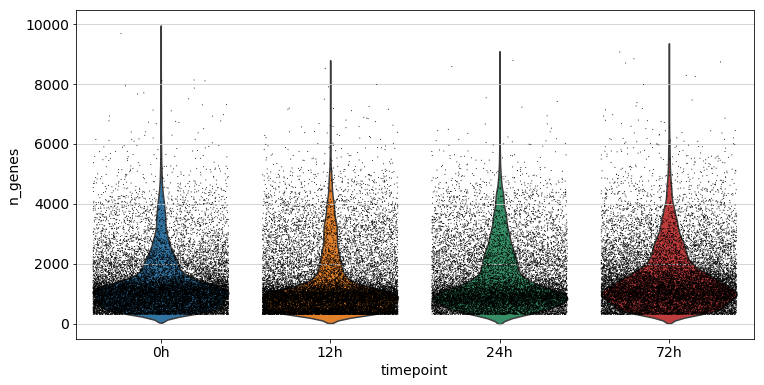

In [31]:
sc.pl.violin(adata, ['n_genes'],
             jitter=0.4, groupby='timepoint')

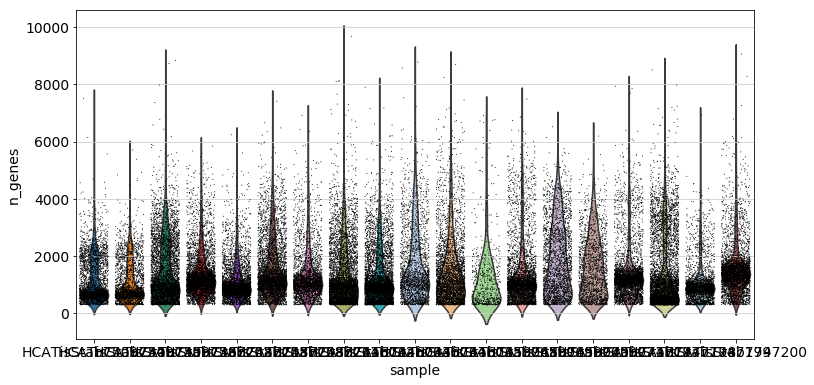

In [33]:
sc.pl.violin(adata, ['n_genes'],
             jitter=0.4, groupby='sample')

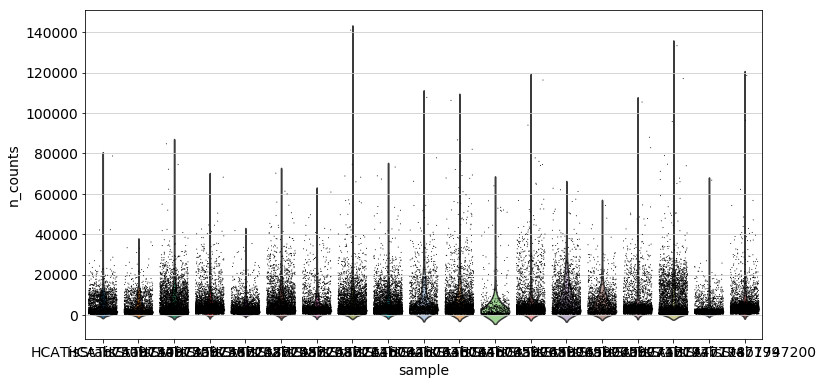

In [32]:
sc.pl.violin(adata, ['n_counts'],
             jitter=0.4, groupby='sample')

Actually do the filtering.

In [34]:
adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['percent_mito'] < 0.1, :]
adata = adata[adata.obs['n_counts'] < 20000, :]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 54659 × 25204 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200', 'n_cells'

Set the `.raw` attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by `sc.pp.log1p`.

In [36]:
adata.raw = sc.pp.log1p(adata, copy=True)

Per-cell normalize the data matrix $\mathbf{X}$. Many people would consider the normalized data matrix as the "relevant data" for visualization and differential testing (assessing feature importance). Until a common viewpoint is reached on this, the decision of what to consider "raw", is up to the user. We tend to recommend to use the normalized data for visualization and differential testing even though here, we use the non-normalized data for the sake of consistency with the Seurat tutorial.

In [37]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Identify highly-variable genes.

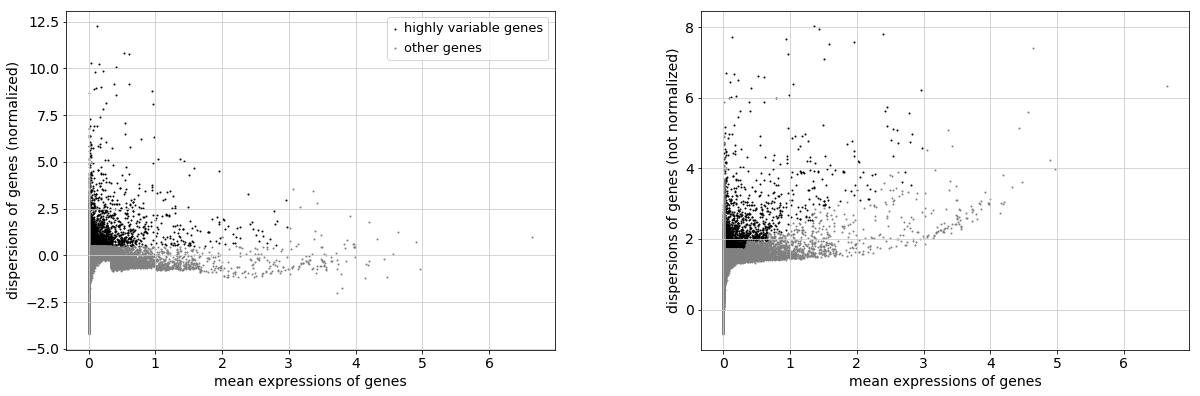

In [38]:
filter_result = sc.pp.filter_genes_dispersion(
    adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)

Actually do the filtering.

In [39]:
adata

AnnData object with n_obs × n_vars = 54659 × 25204 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200', 'n_cells'

In [40]:
adata = adata[:, filter_result.gene_subset]

In [41]:
adata

View of AnnData object with n_obs × n_vars = 54659 × 2624 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200', 'n_cells'

Logarithmize the data.

In [42]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [43]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:01:42.78)


In [44]:
sc.pp.regress_out(adata, ['percent_mito'])

regressing out ['percent_mito']
    finished (0:01:23.09)


In [45]:
sc.pp.regress_out(adata, ['patient'])

regressing out ['patient']
    finished (0:02:08.23)


In [46]:
sc.pp.scale(adata, max_value=10)

Save the result.

In [47]:
#adata.write(results_file)
adata

AnnData object with n_obs × n_vars = 54659 × 2624 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200', 'n_cells'

## PCA

Compute PCA and make a scatter plot.

In [48]:
sc.tl.pca(adata)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.


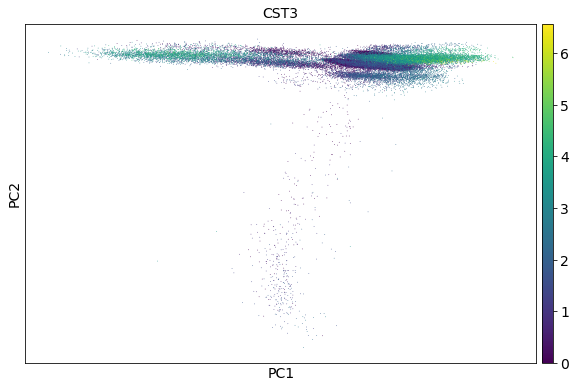

In [49]:
adata.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_scatter(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine. Seurat provides many more functions, here.

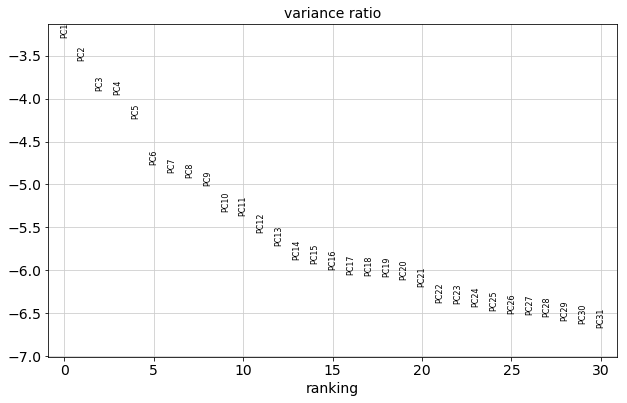

In [50]:
sc.pl.pca_variance_ratio(adata, log=True)

In [51]:
#adata.write(results_file)

In [52]:
adata

AnnData object with n_obs × n_vars = 54659 × 2624 
    obs: 'batch', 'organ', 'patient', 'sample', 'timepoint', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-HCATisStab7509734', 'gene_ids-HCATisStab7509735', 'gene_ids-HCATisStab7509736', 'gene_ids-HCATisStab7587202', 'gene_ids-HCATisStab7587205', 'gene_ids-HCATisStab7587208', 'gene_ids-HCATisStab7587211', 'gene_ids-HCATisStab7646032', 'gene_ids-HCATisStab7646033', 'gene_ids-HCATisStab7646034', 'gene_ids-HCATisStab7646035', 'gene_ids-HCATisStab7659968', 'gene_ids-HCATisStab7659969', 'gene_ids-HCATisStab7659970', 'gene_ids-HCATisStab7659971', 'gene_ids-HCATisStab7747197', 'gene_ids-HCATisStab7747198', 'gene_ids-HCATisStab7747199', 'gene_ids-HCATisStab7747200', 'n_cells'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## BBKNN correction and UMAP plot

In [53]:

bbknn.bbknn(adata, batch_key='patient',neighbors_within_batch = 4)
sc.tl.umap(adata)

computing batch balanced neighbors
    finished (0:00:17.33) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:16.27) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [54]:
sc.tl.louvain(adata,resolution=0.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:12.48) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


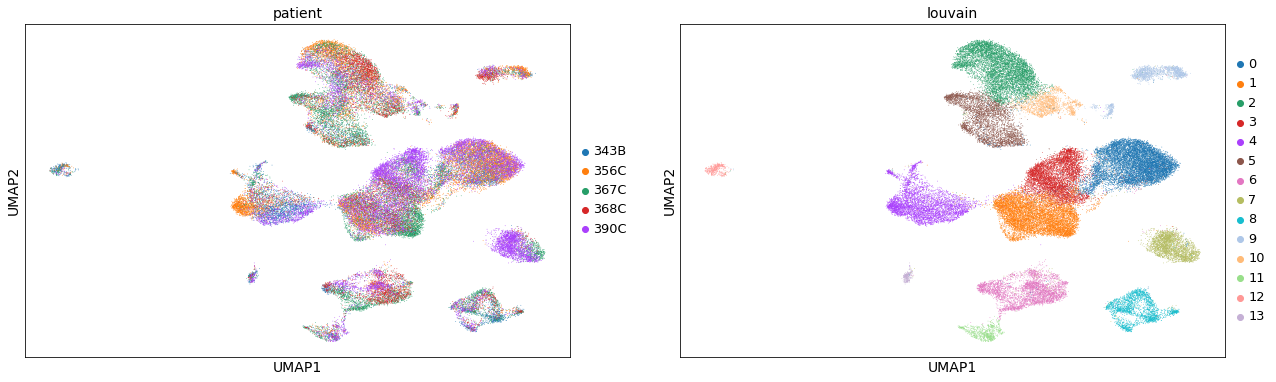

In [55]:
sc.pl.umap(adata,color=['patient','louvain'])

In [56]:
sc.tl.louvain(adata,resolution=1.2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:14.70) --> found 19 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


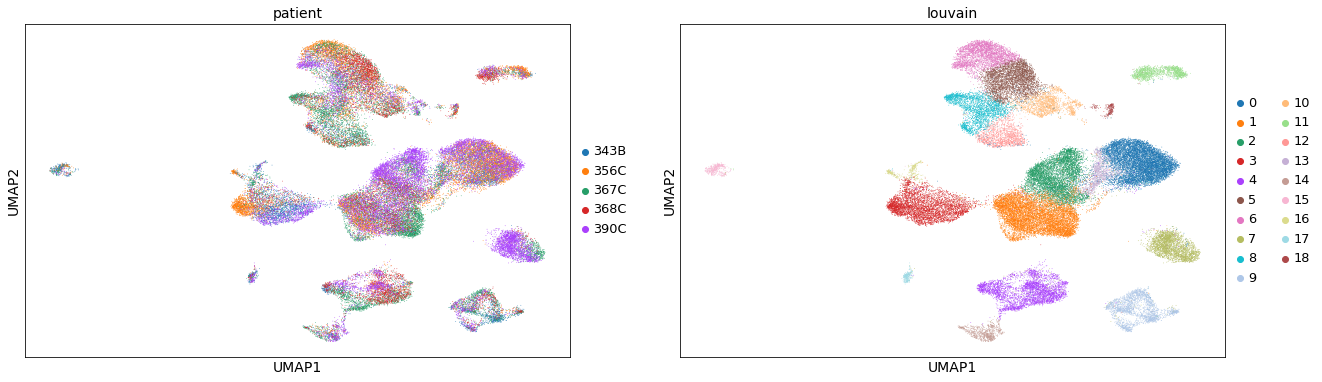

In [57]:
sc.pl.umap(adata,color=['patient','louvain'])

## Saving the data

In [61]:
np.savetxt('bbknn_umap_lng5.txt',adata.obsm['X_umap'])

In [62]:
adata.obsm['X_umap']
adata.obs_names

umap_df = pd.DataFrame(data=adata.obsm['X_umap'], index=adata.obs_names)

umap_df.to_csv('bbknn_umap_lng5.txt')


In [63]:
np.savetxt('bbknn_umap_clusters_res0.9_lng5.txt',[str(i) for i in adata.obs['louvain'].values],fmt='%s')